# Relationship between fixed effects, random effects, GLS, and penalized regression; confounding; model misspecification

In [1]:
library(data.table)
library(ggplot2)
library(lme4)
library(parallel)
library(penalized)
library(xtable)

options(repr.plot.width=6, repr.plot.height=4)
theme_set(theme_bw())

Loading required package: Matrix
Loading required package: survival
Welcome to penalized. For extended examples, see vignette("penalized").


## Prepare Data

In [2]:
literacy.covariates.data <- data.table(subject=c(1:91))
literacy.covariates.data[,base.age:=1 + 0.1*(subject - 1)]
literacy.covariates.data[,`0`:=base.age]
literacy.covariates.data[,`1`:=`0` + (1 + (10 - base.age)/10)^2]
literacy.covariates.data[,`2`:=`1` + (1 + (10 - base.age)/10)^2]
literacy.covariates.data[,subject:=factor(subject)]
literacy.covariates.data <- melt(literacy.covariates.data, id.vars=c('subject', 'base.age'),
                                 value.name='total.age', variable.name='follow.per')
literacy.covariates.data[,follow.per:=factor(as.numeric(follow.per) - 1, ordered=TRUE)]
setkey(literacy.covariates.data, subject, follow.per)
literacy.covariates.data[,delta.age:=total.age - base.age]
head(literacy.covariates.data)

subject,base.age,follow.per,total.age,delta.age
1,1.0,0,1.0000,0.0000
1,1.0,1,4.6100,3.6100
1,1.0,2,8.2200,7.2200
2,1.1,0,1.1000,0.0000
2,1.1,1,4.6721,3.5721
2,1.1,2,8.2442,7.1442


## Response

In [3]:
make.base.literacy <- function(base.age) {
    (10 - base.age)^2
}

make.response <- function(covariates, variance=100) {
    make.base.literacy(covariates$base.age) +
    covariates$delta.age +
    rnorm(n=nrow(covariates), sd=sqrt(variance))
}

## Visualization

png 
  2

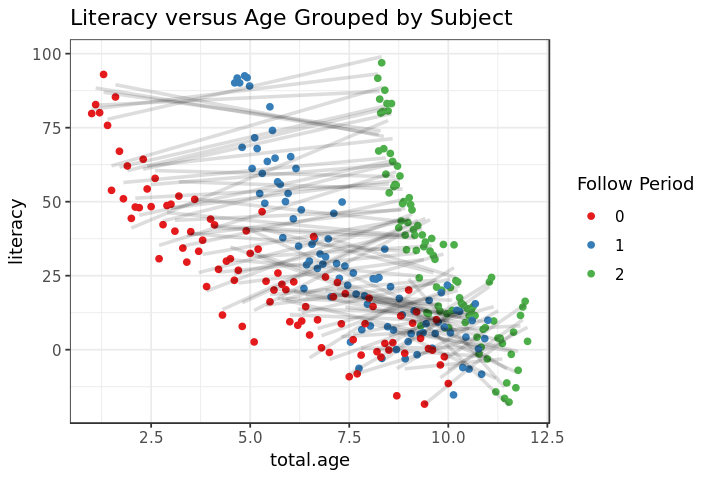

In [4]:
set.seed(2021)
literacy.data <- copy(literacy.covariates.data)
literacy.data[,literacy:=make.response(literacy.data)]

p <- ggplot(literacy.data, aes(x=total.age, y=literacy)) +
  geom_point(aes(color=follow.per)) +
  scale_color_brewer('Follow Period', palette='Set1') + 
  geom_smooth(aes(group=subject), method='lm', se=FALSE, color='#00000022') +
  ggtitle('Literacy versus Age Grouped by Subject')

pdf('literacy_versus_age.pdf', width=6, height=3.75)
p
dev.off()
p

png 
  2

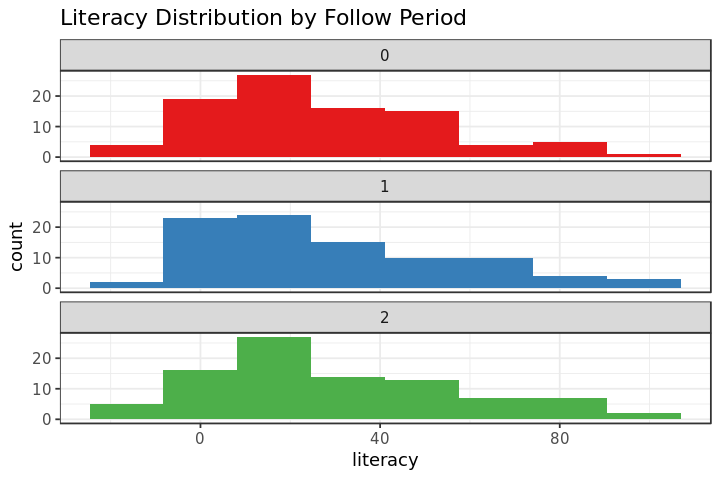

In [5]:
p <- ggplot(literacy.data, aes(x=literacy, fill=follow.per)) +
  geom_histogram(bins=8) +
  scale_fill_brewer('Follow Period', palette='Set1', guide=FALSE) +
  facet_wrap(~follow.per, ncol=1) +
  ggtitle('Literacy Distribution by Follow Period')

pdf('literacy_by_follow_period.pdf', width=6, height=6)
p
dev.off()
p

## Simulation Study: Random versus Fixed Effect Intercept

In [6]:
lmer.simulation.samples <- do.call(
    rbind, mclapply(replicate(8192, literacy.covariates.data, simplify=FALSE),
                    function(covariates) {
    literacy <- make.response(covariates)
    model <- lmer(literacy ~ delta.age + (1|subject), data=covariates, REML=TRUE)
    var.corr <- VarCorr(model)
    data.frame(
        delta.age=fixef(model)[['delta.age']],
        delta.age.std.error=summary(model)$coefficients['delta.age', 'Std. Error'],
        sigma=attributes(var.corr)$sc,
        sigma.random=attributes(var.corr$subject)$stddev[['(Intercept)']])
}, mc.cores=4))

In [7]:
lm.simulation.samples <- do.call(
    rbind, mclapply(replicate(8192, literacy.covariates.data, simplify=FALSE),
                    function(covariates) {
    literacy <- make.response(covariates)
    model <- lm(literacy ~ subject + delta.age, data=covariates)
    model.summary <- summary(model)
    data.frame(
        delta.age=model$coefficients[['delta.age']],
        delta.age.std.error=model.summary$coefficients['delta.age', 'Std. Error'],
        sigma=model.summary$sigma)
    
}, mc.cores=4))

In [8]:
summarize.simulation <- function(data) {
    l <- list(
        `$\\mathbb{E}\\left[\\hat{\\beta}_L\\right]$`=mean(data$delta.age),
        `$\\mathbb{E}\\left[\\hat{\\sigma}_{\\hat{\\beta}_L}\\right]$`=mean(data$delta.age.std.error),
        `Sample $\\hat{\\sigma}_{\\hat{\\beta}_L}$`=sd(data$delta.age),
        `$\\mathbb{E}\\left[\\hat{\\sigma}\\right]$`=mean(data$sigma))
    l[['$\\mathbb{E}\\left[\\hat{\\sigma}_{\\gamma}\\right]$']] <- if ('sigma.random' %in% names(data)) {
        mean(data$sigma.random)
    } else {
        NA
    }
    l
}

In [9]:
simulation.comparison <- as.data.frame(rbind(
    data.table(lmer.simulation.samples)[,summarize.simulation(.SD)],
    data.table(lm.simulation.samples)[,summarize.simulation(.SD)]))
row.names(simulation.comparison) <- c('Random Effects Intercept', 'Fixed Effects Intercept')
simulation.comparison

,$\mathbb{E}\left[\hat{\beta}_L\right]$,$\mathbb{E}\left[\hat{\sigma}_{\hat{\beta}_L}\right]$,Sample $\hat{\sigma}_{\hat{\beta}_L}$,$\mathbb{E}\left[\hat{\sigma}\right]$,$\mathbb{E}\left[\hat{\sigma}_{\gamma}\right]$
Random Effects Intercept,1.2779277,0.3208065,0.3279972,10.007446,24.3412
Fixed Effects Intercept,0.9969691,0.3213570,0.3199906,9.980246,NA


In [10]:
print(xtable(simulation.comparison,
             caption=paste('\\small Results of a simulation study comparing modeling the ',
                           'subject-specific intercepts as a random effect or fixed effect.',
                           'Parameter estimates were averaged over simulations. Standard errors',
                           'for $\\hat{\\beta_L}$ are calculated two ways:',
                           '(1) assuming the model is correct',
                           '($\\mathbb{E}\\left[\\hat{\\sigma}_{\\hat{\\beta}_L}\\right]$),',
                           'and (2) using the $\\hat{\\beta_L}$ samples',
                           '(Sample $\\hat{\\sigma}_{\\hat{\\beta}_L}$).'),
             label='tab:simulation_comparison',
             digits=c(0, 6, 6, 6, 6, 6)),
      booktabs=TRUE,
      sanitize.colnames.function=identity,
      sanitize.rownames.function=identity,
      size='small',
      file='simulation_comparison.tex')

## $\sigma_\gamma$ Calculation

In [11]:
base.literacy <- make.base.literacy(literacy.covariates.data[follow.per==0]$base.age)
variance.random.intercept <- mean((base.literacy - mean(base.literacy))^2)
sqrt(variance.random.intercept)

[1] 24.43306

## Expected $\hat{\beta}$

### GLS

In [12]:
expect.beta.hat.gls <- function(residual.variance) {
    subject.covariance.inv <- chol2inv(chol(
        as.matrix(nlme::pdCompSymm(variance.random.intercept + diag(3)*residual.variance))))
    projected.data <- lapply(levels(literacy.covariates.data$subject), function(i) {
        data <- literacy.covariates.data[J(i)]
        X <- cbind(1, data$delta.age)
        tX <- t(X)
        list(X=tX %*% subject.covariance.inv %*% X,
             y=tX %*% subject.covariance.inv %*% make.response(data, 0))
    })    
    projected.X <- Reduce(
        `+`, lapply(projected.data, function(projection) { projection$X }))
    projected.y <- Reduce(
        `+`, lapply(projected.data, function(projection) { projection$y }))    
    r <- chol(projected.X)  # Upper trianglar
    beta.hat <- as.vector(backsolve(r, forwardsolve(r, projected.y, upper.tri=TRUE, transpose=TRUE)))
    names(beta.hat) <- c('(Intercept)', 'delta.age')        
    beta.hat
}

### Ridge Regression

In [13]:
expect.beta.hat.ridge <- function(residual.variance) {
    X <- cbind(1, model.matrix(~ 0 + delta.age + subject, literacy.covariates.data))
    y <- make.response(literacy.covariates.data, 0)
    # Penalize only random effects.
    Q <- diag(ncol(X))
    Q[1, 1] <- 0
    Q[2, 2] <- 0
    # Estimate beta
    tX <- t(X)
    r <- chol(tX %*% X + residual.variance/variance.random.intercept*Q)
    beta.hat <- as.vector(backsolve(r, forwardsolve(r, tX %*% y, upper.tri=TRUE, transpose=TRUE)))
    names(beta.hat) <- colnames(X)
    names(beta.hat)[1] <- '(Intercept)'
    beta.hat
}

### Penalized Regression

In [14]:
expect.beta.hat.penalized <- function(residual.variance) {
    coef(penalized(make.response(literacy.covariates.data, 0),
                   unpenalized=~delta.age,
                   penalized=~subject,                       
                   data=literacy.covariates.data,
                   lambda2=residual.variance/variance.random.intercept))
}

In [15]:
expect.beta.hat.gls(100)['delta.age']
expect.beta.hat.ridge(100)['delta.age']
expect.beta.hat.penalized(100)['delta.age']

delta.age 
 1.272883

delta.age 
 1.272883

delta.age 
 1.272883

### Bias as a Function of $\sigma^2$

png 
  2

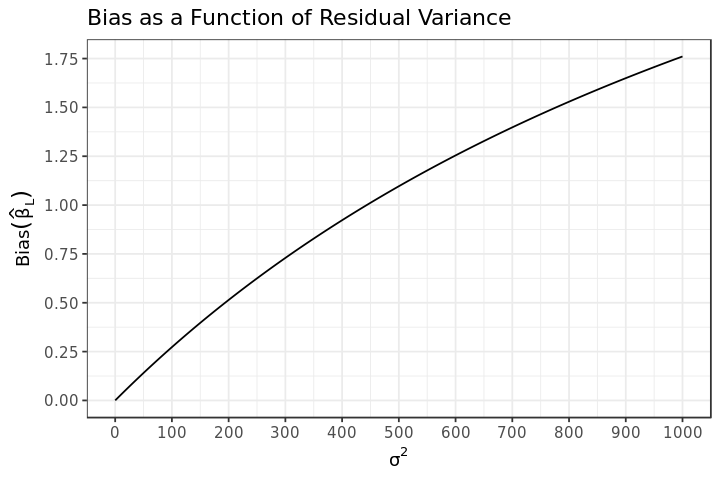

In [16]:
bias.data <- data.table(residual.variance=c(seq(0.1, by=0.1, length.out=9), 1:1000))
bias.data[,bias:=do.call(c, mclapply(
    residual.variance,
    function(residual.variance) { expect.beta.hat.ridge(residual.variance)[['delta.age']] },
    mc.cores=4)) - 1]

p <- ggplot(bias.data, aes(x=residual.variance, y=bias)) +
  geom_line() +
  scale_x_continuous(expression(sigma^2), breaks=seq(0, 1000, by=100)) +
  scale_y_continuous(expression(Bias(hat(beta)[L])), breaks=seq(0, 1.75, by=0.25)) + 
  ggtitle('Bias as a Function of Residual Variance')

pdf('bias_variance_plot.pdf', width=6, height=3.75)
p
dev.off()
p